In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from keras.preprocessing.text import Tokenizer
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ncu-im5033-polarity-21/sample_submission.csv
/kaggle/input/ncu-im5033-polarity-21/test_no_answer.csv
/kaggle/input/ncu-im5033-polarity-21/train.csv


In [44]:
df_train = pd.read_csv('/kaggle/input/ncu-im5033-polarity-21/train.csv')
df_test = pd.read_csv('/kaggle/input/ncu-im5033-polarity-21/test_no_answer.csv')
df_train

,row_id,TEXT,LABEL
0,0,good to know if you can t find these elsewhere .,1
1,1,love it ! the grill plates come out and pop i...,1
2,2,i m convinced this was a poorly executed refur...,0
3,3,i would never have complained about that if it...,0
4,4,"the photo shows the same whole , large candie...",0
...,...,...,...
10995,10995,i didn t quite get it the first time .,1
10996,10996,i ve tried installing with and without the oem...,0
10997,10997,i was parked at a truck stop in the cincinnati...,0
10998,10998,i recently bought this case after seeing some ...,1


### Preprocessing text for the (supervised) Text-CNN model
The following cells uses Keras to preprocess text:

- using a tokenizer. You may use different tokenizers (from scikit-learn, NLTK, custom Python function etc.). This converts the texts into sequences of indices representing the 20000 most frequent words
- sequences have different lengths, so we pad them (add 0s at the end until the sequence is of length 1000)
- we convert the output classes as 1-hot encodings

In [45]:
# get the raw text data
texts_train = df_train['TEXT'].astype(str)
texts_test = df_test['TEXT'].astype(str)

fixed negative words, 但是bert是word piece, 或許不用錢處理。

In [46]:
negative_words = ["can t","couldn t","wouldn t","shouldn t","ain t",
                  "didn t","don t","doesn t",
                  "wasn t","isn t","aren t","hasn t","haven t","won t"]

mapping = {}
for n in negative_words:
    mapping[n] = "'".join(n.split())

In [47]:
# apply to dataframe
def cat_negative_words(sentence):
    for n in negative_words:
        sentence = sentence.replace(n, mapping[n])
    return sentence

df_train['TEXT'] = df_train['TEXT'].apply(lambda x: cat_negative_words(x) )
df_test['TEXT']  = df_test['TEXT'].apply(lambda x: cat_negative_words(x) )
df_train.head(3)

,row_id,TEXT,LABEL
0,0,good to know if you can't find these elsewhere .,1
1,1,love it ! the grill plates come out and pop i...,1
2,2,i m convinced this was a poorly executed refur...,0


In [48]:
x_train = df_train['TEXT']
x_test = df_test['TEXT']

In [49]:
# raw train/valid split
from sklearn.model_selection import train_test_split
y_train = np.asarray(df_train['LABEL']) # has label as answer
# x_train, x_val, y_train, y_val = train_test_split(texts_train, y_train, test_size=0.2, random_state=42) # raw
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42) # processed

In [50]:
print('Shape of x_train:', x_train.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of x_val:', x_val.shape)
print('Shape of y_val:', y_val.shape)

Shape of x_train: (8800,)
Shape of y_train: (8800,)
Shape of x_val: (2200,)
Shape of y_val: (2200,)


### Model : A BERT encoder + simple Text-CNN model in Keras
[tensorflow: classify_text_with_bert](https://www.tensorflow.org/tutorials/text/classify_text_with_bert)
- Load a BERT model from TensorFlow Hub
- Build your own model by combining BERT with a classifier
- Train your own model, fine-tuning BERT as part of that  

In [8]:
!pip install -q tensorflow-text # A dependency of the preprocessing for BERT inputs

In [9]:
!pip install -q tf-models-official # You will use the AdamW optimizer from tensorflow/models.

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.4.3 requires tensorflow<2.5,>=2.4.0, but you have tensorflow 2.5.0 which is incompatible.


In [10]:
! pip freeze | grep tensorflow 

tensorflow==2.5.0
tensorflow-addons @ file:///tmp/tfa_cpu/tensorflow_addons-0.12.1-cp37-cp37m-linux_x86_64.whl
tensorflow-cloud==0.1.13
tensorflow-datasets==3.0.0
tensorflow-estimator==2.5.0
tensorflow-gcs-config @ file:///tmp/tensorflow_gcs_config/tensorflow_gcs_config-2.1.7-py3-none-any.whl
tensorflow-hub==0.12.0
tensorflow-metadata==0.29.0
tensorflow-model-optimization==0.5.0
tensorflow-probability==0.12.2
tensorflow-text==2.4.3


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.4.3 requires tensorflow<2.5,>=2.4.0, but you have tensorflow 2.5.0 which is incompatible.

In [11]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
tf.get_logger().setLevel('ERROR')

#### Choose a BERT model to fine-tune

In [12]:
# bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1' # BERT model
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3' # Preprocess model

#### The preprocessing model
Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT. TensorFlow Hub provides a matching preprocessing model for each of the BERT models discussed above, which implements this transformation using TF ops from the TF.text library. It is not necessary to run pure Python code outside your TensorFlow model to preprocess text.

The preprocessing model must be the one referenced by the documentation of the BERT model, which you can read at the URL printed above. For BERT models from the drop-down above, the preprocessing model is selected automatically.

Note: You will load the preprocessing model into a [hub.KerasLayer](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) to compose your fine-tuned model. This is the preferred API to load a TF2-style SavedModel from TF Hub into a Keras model.

In [13]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


As you can see, now you have the 3 outputs from the preprocessing that a BERT model would use (`input_words_id`, `input_mask` and `input_type_ids`).  

Some other important points:

- The input is truncated to 128 tokens. The number of tokens can be customized, and you can see more details on the Solve GLUE tasks using BERT on a TPU colab.
- The `input_type_ids` only have one value (0) because this is a single sentence input. For a multiple sentence input, it would have one number for each input.
- Since this text preprocessor is a TensorFlow model, It can be included in your model directly.

#### Using the BERT model
Before putting BERT into your own model, let's take a look at its outputs. You will load it from TF Hub and see the returned values.

In [14]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}') # [batch_size, H]
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}') # [batch_size, seq_length, H]
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.7626289   0.9928099  -0.18611847  0.36673844  0.15233688  0.6550448
  0.9681154  -0.948627    0.00216161 -0.9877732   0.06842694 -0.97630596]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.2894631   0.34321257  0.33231482 ...  0.2130079   0.710208
  -0.05771104]
 [-0.28741983  0.31981012 -0.2301856  ...  0.584551   -0.21329626
   0.7269212 ]
 [-0.6615694   0.68876845 -0.87433046 ...  0.10877308 -0.2617321
   0.47855446]
 ...
 [-0.22561106 -0.28925565 -0.07064411 ...  0.4756602   0.8327715
   0.40025333]
 [-0.29824218 -0.27473184 -0.05450517 ...  0.48849645  1.0955355
   0.1816338 ]
 [-0.44378152  0.00930741  0.07223725 ...  0.17290096  1.1833245
   0.0789802 ]]


The BERT models return a map with 3 important keys: pooled_output, sequence_output, encoder_outputs:

- `pooled_output` represents each input sequence as a whole. The shape is [batch_size, H]. You can think of this as an embedding for the entire movie review.
- `sequence_output` represents each input token in the context. The shape is [batch_size, seq_length, H]. You can think of this as a contextual embedding for every token in the movie review.
- `encoder_outputs` are the intermediate activations of the L Transformer blocks. outputs["encoder_outputs"][i] is a Tensor of shape [batch_size, seq_length, 1024] with the outputs of the i-th Transformer block, for 0 <= i < L. The last value of the list is equal to sequence_output.

For the fine-tuning you are going to use the `pooled_output` array.

### Define your model
You will create a very simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense and a Dropout layer.

In [15]:
# Model Hyperparameters
EMBEDDING_DIM = 128        # paper is 300
N_CLASSES = 2
filter_sizes = (3, 4, 5)
num_filters = 100          # paper is 100
dropout_prob = (0.5, 0.5)
hidden_dims = 100          # paper is 100

In [16]:
def build_classifier_model():
    # Input-text & embedding layer
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing') # text process
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT-encoder') # encoder
    outputs = encoder(encoder_inputs)
    net = outputs['sequence_output']
    net = tf.keras.layers.Dropout(dropout_prob[0])(net)
    
    # Convolutional block
    conv_blocks = []
    for sz in filter_sizes:
        conv = tf.keras.layers.Convolution1D(filters     = num_filters,
                                             kernel_size = sz,
                                             padding     = "valid",
                                             activation  = "relu",
                                             strides     = 1)(net)
        conv = tf.keras.layers.MaxPooling1D(pool_size = 2)(conv)
        conv = tf.keras.layers.Flatten()(conv)
        conv_blocks.append(conv)
    net = tf.keras.layers.Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]

    # Dropout & fully-connected
    net = tf.keras.layers.Dropout(dropout_prob[1])(net)
    net = tf.keras.layers.Dense(hidden_dims, activation='relu', name='fully-connected')(net)
    net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [51]:
# Let's check that the model runs with the output of the preprocessing model.
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.5741993]], shape=(1, 1), dtype=float32)


In [52]:
classifier_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_mask': (None 0           text[0][0]                       
__________________________________________________________________________________________________
BERT-encoder (KerasLayer)       {'default': (None, 5 28763649    preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
____________________________________________________________________________________________

### Model training

In [53]:
# Loss function
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

#### Optimizer  
For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as AdamW.

For the learning rate (init_lr), you will use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (num_warmup_steps). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [54]:
# Training parameters
batch_size = 64 # paper is 50 

# Optimizer
epochs = 20      # paper is 25
steps_per_epoch = len(x_train)
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [55]:
classifier_model.compile(optimizer=optimizer, # 我不會客製化!!!! https://huggingface.co/transformers/v2.3.0/_modules/transformers/optimization_tf.html
                         loss=loss,
                         metrics=metrics)

In [60]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x_train, y_train, 
                               validation_data=(x_val,y_val),
                               epochs=5,             # 再 train 5 epoch
                               batch_size=batch_size)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
138/138 [==============================] - 58s 423ms/step - loss: 0.4621 - binary_accuracy: 0.7775 - val_loss: 0.5195 - val_binary_accuracy: 0.7364
Epoch 2/5
138/138 [==============================] - 58s 420ms/step - loss: 0.4444 - binary_accuracy: 0.7862 - val_loss: 0.5366 - val_binary_accuracy: 0.7341
Epoch 3/5
138/138 [==============================] - 58s 422ms/step - loss: 0.4315 - binary_accuracy: 0.7972 - val_loss: 0.5058 - val_binary_accuracy: 0.7505
Epoch 4/5
138/138 [==============================] - 58s 421ms/step - loss: 0.4146 - binary_accuracy: 0.8125 - val_loss: 0.5047 - val_binary_accuracy: 0.7527
Epoch 5/5
138/138 [==============================] - 59s 427ms/step - loss: 0.3979 - binary_accuracy: 0.8193 - val_loss: 0.5184 - val_binary_accuracy: 0.7455


- 20 epoch => val_loss: 0.5221 - val_binary_accuracy: 0.7291
- 30 epoch => loss: 0.3034 - binary_accuracy: 0.8714 - val_loss: 0.5493 - val_binary_accuracy: 0.7623
- submit => 64.24%

In [61]:
loss, accuracy = classifier_model.evaluate(x_val,y_val)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

69/69 [==============================] - 6s 92ms/step - loss: 0.5184 - binary_accuracy: 0.7455
Loss: 0.5183740258216858
Accuracy: 0.7454545497894287


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


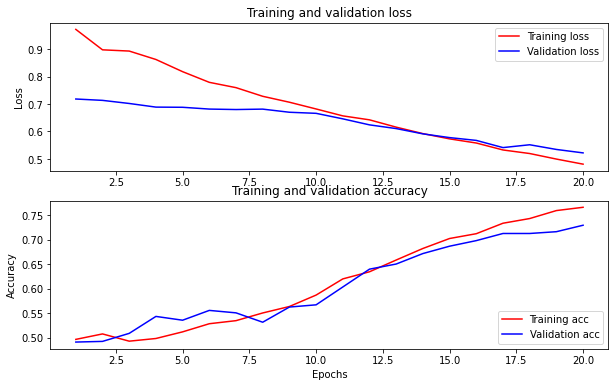

In [58]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [67]:
# save model
saved_model_path = './bert_25epoch_a.h5'

classifier_model.save(saved_model_path, include_optimizer=False)

In [31]:
!ls

__notebook_source__.ipynb  bert  bert_30epoch


#### Submit

In [62]:
output_test = classifier_model.predict(x_test)
print(output_test[:5])
print(output_test.shape)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
[[0.04246995]
 [0.10430083]
 [0.45688352]
 [0.02374457]
 [0.09600452]]
(2000, 1)


In [63]:
y_classes = [1 if x > 0.5 else 0 for x in output_test]
y_classes[:5]

[0, 0, 0, 0, 0]

In [64]:
submission = {
    'row_id': list(range(0,len(output_test))),
    'LABEL': y_classes
}
submission = pd.DataFrame.from_dict(submission)
submission.head(5)

,row_id,LABEL
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [65]:
submission['LABEL'].value_counts()

0    1274
1     726
Name: LABEL, dtype: int64

In [66]:
submission.to_csv('./[實驗8a] textcnn non-static (BERT).csv', index=False)